# Raport week 2
**M. Krzyziński, M. Spytek, M. Ziemła**

Zdecydowaliśmy się głównie zająć różnicami dotyczącymi epidemii koronawirusa w krajach na różnym etapie rozwoju gospodarczego. Wybraliśmy [klasyfikację World Banku](https://blogs.worldbank.org/opendata/new-world-bank-country-classifications-income-level-2020-2021), która dzieli kraje na cztery kategorie:
- Low income	< 1,036 (GNI/capita adjusted for inflation)
- Lower-middle income	1,036 - 4,045	(GNI/capita adjusted for inflation)
- Upper-middle income	4,046 - 12,535(GNI/capita adjusted for inflation)
- High income > 12,535 (GNI/capita adjusted for inflation)

Na podstawie tego podziału grupowaliśmy kraje na kategorie w części wykresów. 

Posłużyliśmy się również [dodatkowym zbiorem danych](https://www.google.com/covid19/mobility/), udostępnianym przez Google. Dotyczy on głównie zmian mobilności w krajach, względem unormowanego okresu z poczatku roku. Można tam znaleźć informacje m. in. jak zmieniło się użytkowanie transportu publicznego, czy też jak spadło uczęszczanie do miejsc rozrywki, w zależności od państwa i daty.




In [1]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(rc={'figure.figsize':(12,8)})

datagoogle = pd.read_csv("https://www.gstatic.com/covid19/mobility/Global_Mobility_Report.csv")
dataowid = pd.read_csv("https://raw.githubusercontent.com/owid/covid-19-data/master/public/data/owid-covid-data.csv")

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (4) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [2]:
transitdown = datagoogle[["country_region", "retail_and_recreation_percent_change_from_baseline",	"grocery_and_pharmacy_percent_change_from_baseline", 	"parks_percent_change_from_baseline", "transit_stations_percent_change_from_baseline",	"workplaces_percent_change_from_baseline",	"residential_percent_change_from_baseline"]].groupby("country_region").mean()

hdi = dataowid[["location", "human_development_index", "population"]].groupby("location").mean().dropna()

cont = dataowid[["location","continent"]].groupby("location").max().dropna()

hdi = hdi.join(cont, how="inner")

res = transitdown.join(hdi, how = "inner")


## Wpływ epidemii na mobilność
W tej części analizujemy głównie dane ze zbioru Googla, w połączeniu z danymi ekonomicznymi, z world banku


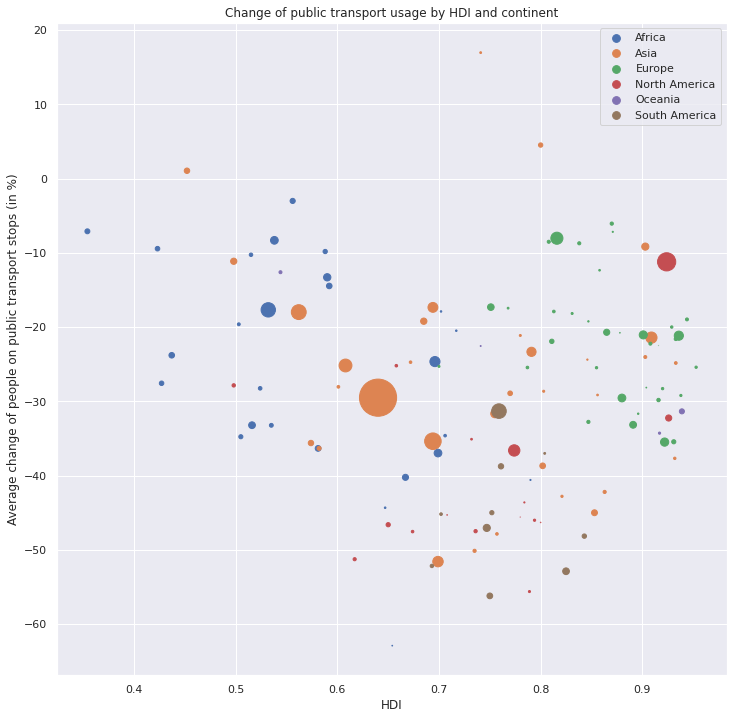

In [3]:
plt.figure(figsize=(12,12))
groups = res.groupby('continent')
for name, group in groups:
    plt.scatter(group["human_development_index"], group["transit_stations_percent_change_from_baseline"], s=group["population"]/1000000, label=name)
l = plt.legend()
for handle in l.legendHandles:
    handle._sizes = [60]
plt.xlabel("HDI")
plt.ylabel("Average change of people on public transport stops (in %)")
plt.title("Change of public transport usage by HDI and continent")
left, right = plt.xlim()
up ,down = plt.ylim()
plt.show()

Europa w znacznym stopniu polega na transporcie publiczym, stąd niska zmiana
HDI koreluje z ilością oraz poleganiu na transporcie publicznym. To jedyny sensowny "klaster", który łatwo wyróżnić na tym wykresie.


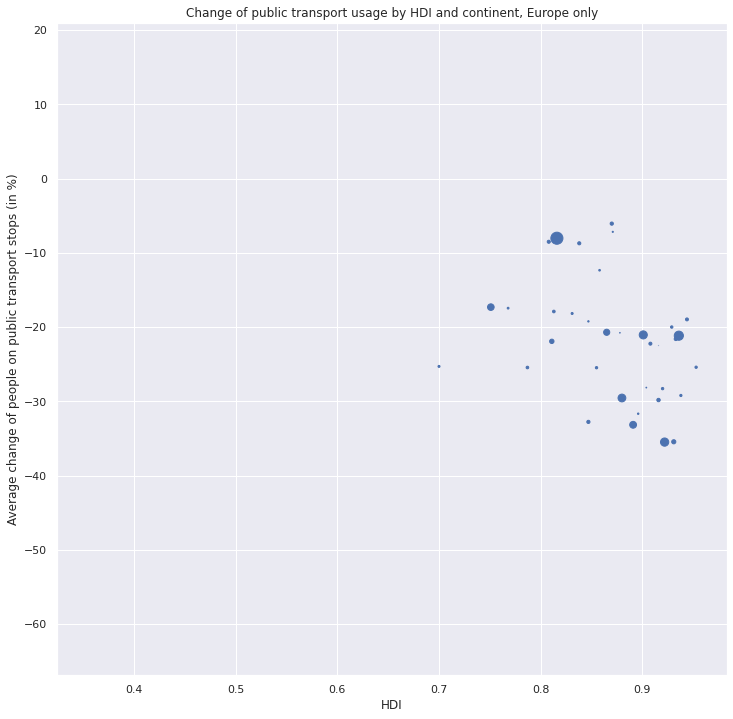

In [4]:
plt.figure(figsize=(12,12))
eu = res[res["continent"]=="Europe"]
plt.scatter(eu["human_development_index"], eu["transit_stations_percent_change_from_baseline"], s=eu["population"]/1000000, label=name)
plt.xlabel("HDI")
plt.ylabel("Average change of people on public transport stops (in %)")
plt.title("Change of public transport usage by HDI and continent, Europe only")
plt.xlim(left,right)
plt.ylim(up,down)
plt.show()

Zauważalny jest lekki trend spadkowy, może to oznaczać, że ludzie z krajów bardziej rozwiniętych (większe HDI - po prawej stronie) mogli się przesiąść do własnych samochodów.

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


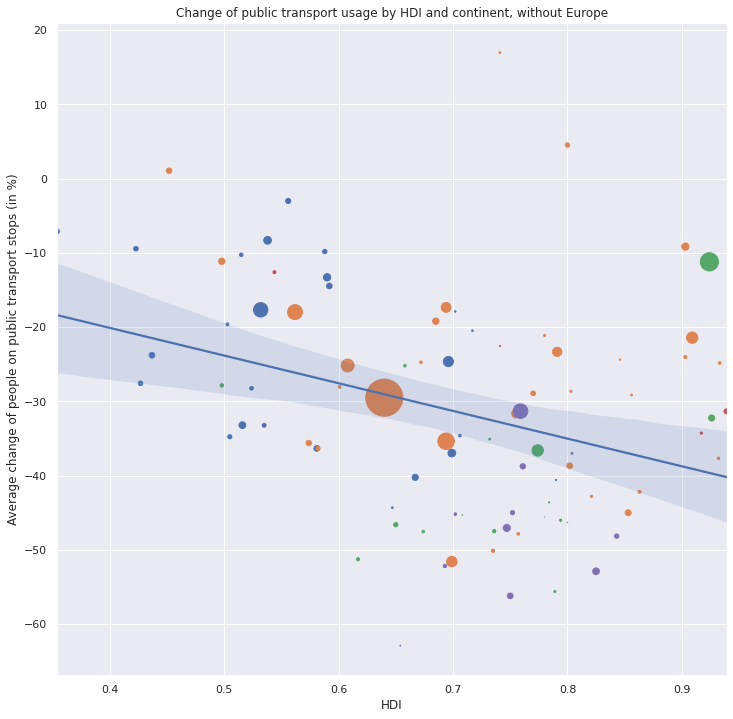

In [5]:
plt.figure(figsize=(12,12))
groups = res.groupby('continent')
data = res[res["continent"]!="Europe"]
for name, group in groups:
    if name=="Europe":
        continue
    plt.scatter(group["human_development_index"], group["transit_stations_percent_change_from_baseline"], s=group["population"]/1000000, label=name)

sns.regplot(scatter=False,x="human_development_index",y="transit_stations_percent_change_from_baseline",data=data,robust=True)
plt.xlabel("HDI")
plt.ylabel("Average change of people on public transport stops (in %)")
plt.title("Change of public transport usage by HDI and continent, without Europe")
plt.show()

In [6]:
mdf = pd.read_excel("http://databank.worldbank.org/data/download/site-content/CLASS.xls", "Groups")


In [7]:
mdf = mdf[mdf["GroupName"].isin(["High income", "Lower middle income", "Low income", "Upper middle income"])]
mdf = mdf[["GroupName", "CountryName"]]
mdf
new = mdf.reset_index(drop=True)
newer = new.set_index("CountryName")
newer

datavis = res.join(newer, how="inner")


Na następnym wykresie przedstawiliśmy wzrost w dzielnicach mieszkalnych, w zestwieniu ze spadkiem w transporcie publicznym. Na tych danych widać, że dane są silnie skorelowane, niezależnie od kategorii zamożności. Wszędzie wzrost aktywności w dzielnicach mieszkalnych pociąga za sobą spadek użycia transportu publicznego.


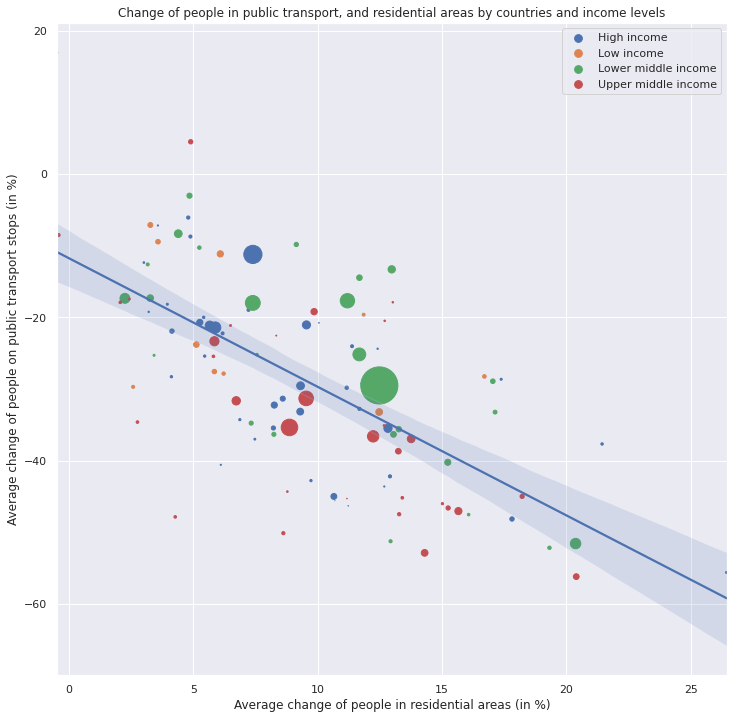

In [8]:
plt.figure(figsize=(12,12))
groups = datavis.groupby('GroupName')
for name, group in groups:
    plt.scatter(group["residential_percent_change_from_baseline"], group["transit_stations_percent_change_from_baseline"], s=group["population"]/1000000, label=name)
l = plt.legend()
for handle in l.legendHandles:
    handle._sizes = [60]

sns.regplot(x="residential_percent_change_from_baseline",y="transit_stations_percent_change_from_baseline",scatter=False,data=datavis,robust=True)
plt.xlabel("Average change of people in residential areas (in %)")
plt.ylabel("Average change of people on public transport stops (in %)")
plt.title("Change of people in public transport, and residential areas by countries and income levels")
plt.show()

## Wpływ na przebywanie w pracy 


Mieszkańcy biednych krajów nie mogą sobie pozwolić na niechodzenie do pracy lub pracują w miejscach które ich wykorzystują. Może się to też zależeć od tego, że w krajach mniej zamożnych jest mniej pracy, którą można wykonać zdalnie.


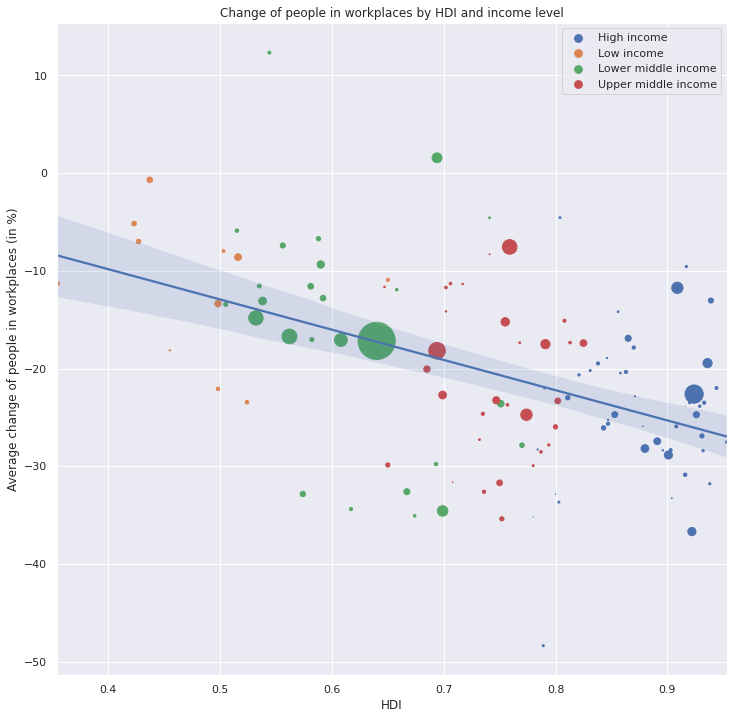

In [9]:
plt.figure(figsize=(12,12))
groups = datavis.groupby('GroupName')
for name, group in groups:
    plt.scatter(group["human_development_index"], group["workplaces_percent_change_from_baseline"], s=group["population"]/1000000, label=name)
l = plt.legend()
for handle in l.legendHandles:
    handle._sizes = [60]
sns.regplot(x="human_development_index",y="workplaces_percent_change_from_baseline",scatter=False,data=datavis,robust=True)
plt.xlabel("HDI")
plt.ylabel("Average change of people in workplaces (in %)")
plt.title("Change of people in workplaces by HDI and income level")
left, right = plt.xlim()
up ,down = plt.ylim()
plt.show()

In [10]:
datavis[datavis["workplaces_percent_change_from_baseline"]>0][["workplaces_percent_change_from_baseline","human_development_index"]]

,workplaces_percent_change_from_baseline,human_development_index
Papua New Guinea,12.338129,0.544
Vietnam,1.572799,0.694


Papua miała mniej niż tysiąc przypadków - więcej pracy bo większy popyt?
Vietnam produkuje sporo rzeczy dla zachodu

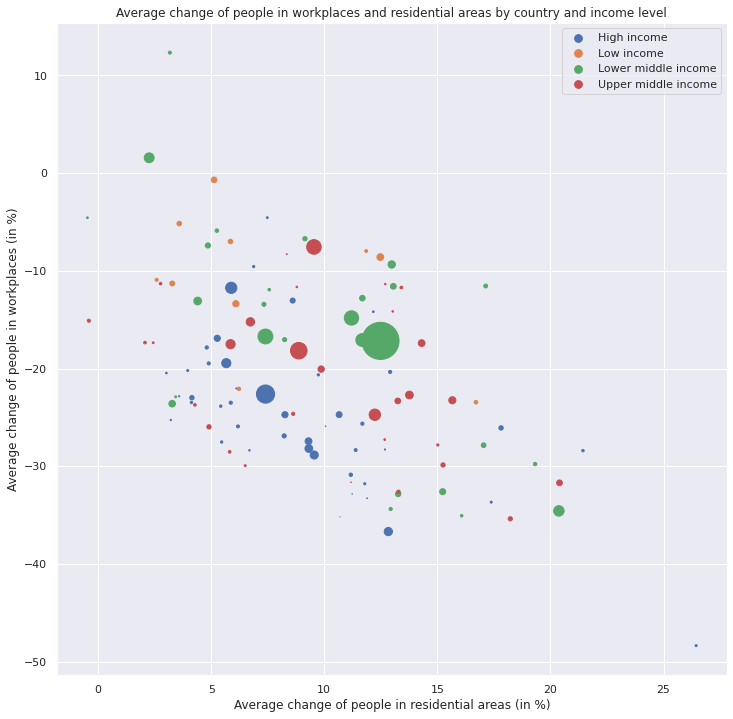

In [11]:
plt.figure(figsize=(12,12))
groups = datavis.groupby('GroupName')
for name, group in groups:
    plt.scatter(group["residential_percent_change_from_baseline"], group["workplaces_percent_change_from_baseline"], s=group["population"]/1000000, label=name)
l = plt.legend()
for handle in l.legendHandles:
    handle._sizes = [60]
plt.xlabel("Average change of people in residential areas (in %)")
plt.ylabel("Average change of people in workplaces (in %)")
plt.title("Average change of people in workplaces and residential areas by country and income level")
plt.show()


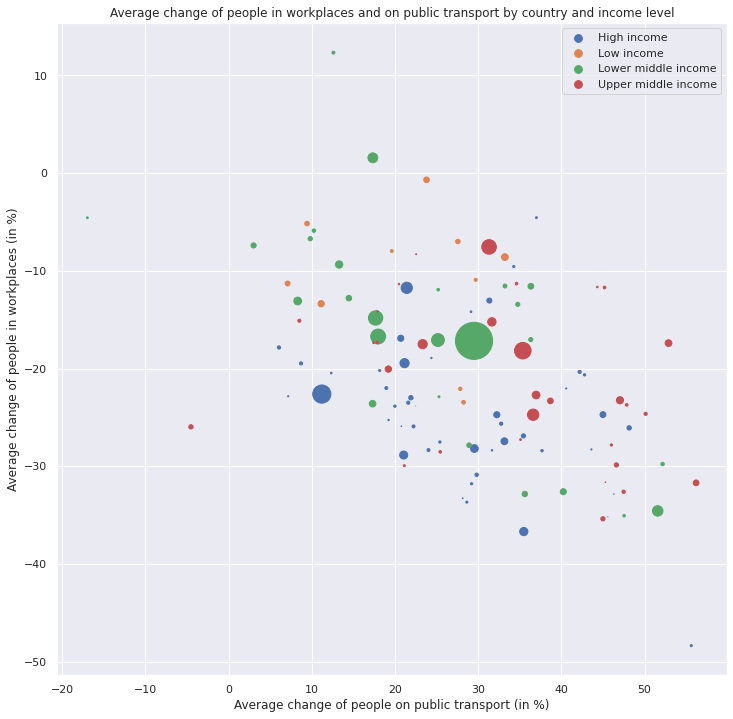

In [12]:
plt.figure(figsize=(12,12))
groups = datavis.groupby('GroupName')
for name, group in groups:
    plt.scatter(-group["transit_stations_percent_change_from_baseline"], group["workplaces_percent_change_from_baseline"], s=group["population"]/1000000, label=name)
l = plt.legend()
for handle in l.legendHandles:
    handle._sizes = [60]
plt.xlabel("Average change of people on public transport (in %)")
plt.ylabel("Average change of people in workplaces (in %)")
plt.title("Average change of people in workplaces and on public transport by country and income level")
plt.show()


<Figure size 4608x1008 with 0 Axes>

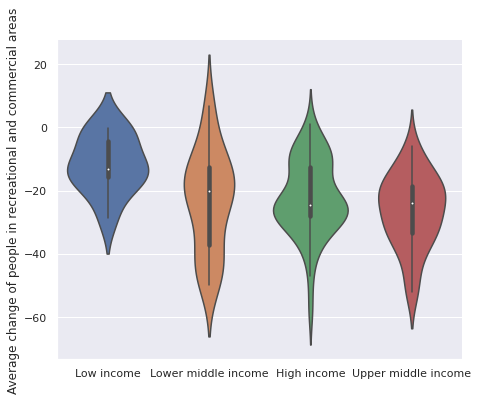

In [13]:
plt.figure(figsize=(64,14))
datavis = datavis.dropna()
sns.catplot(x="GroupName", y="retail_and_recreation_percent_change_from_baseline", data = datavis,kind="violin",aspect=1.3)
plt.ylabel("Average change of people in recreational and commercial areas")
plt.xlabel("")
plt.show()

In [14]:
# sns.catplot(x="GroupName", y="workplaces_percent_change_from_baseline", data = datavis)

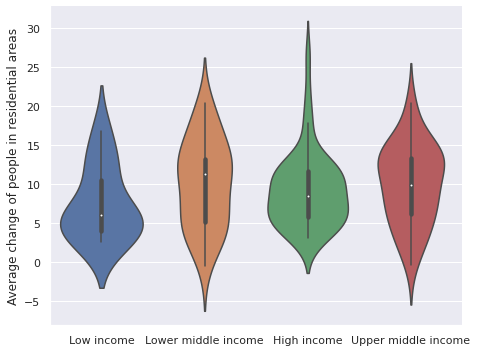

In [15]:
# fig,axs = plt.subplots(1,2,sharey=True)
sns.catplot(x="GroupName", y="residential_percent_change_from_baseline", data = datavis,kind="violin",aspect=1.3)
plt.ylabel("Average change of people in residential areas")
plt.xlabel("")
# sns.catplot(x="GroupName", y="residential_percent_change_from_baseline", data = datavis,ax=axs[1])
plt.show()

In [16]:
df2 = pd.read_csv("https://www.gstatic.com/covid19/mobility/Global_Mobility_Report.csv")

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (4) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [17]:
df1 = pd.read_csv("https://raw.githubusercontent.com/owid/covid-19-data/master/public/data/owid-covid-data.csv")

In [18]:
mdf = pd.read_excel("http://databank.worldbank.org/data/download/site-content/CLASS.xls", "Groups")
mdf = mdf[mdf["GroupName"].isin(["High income", "Lower middle income", "Low income", "Upper middle income"])]
mdf = mdf[["CountryCode", "GroupName", "CountryName"]].reset_index()
df = mdf.set_index("CountryCode").join(df1.set_index("iso_code"))
df["fatality_rate"] = df["total_deaths"]/df["total_cases"]

In [19]:
df["date"] = pd.to_datetime(df['date'], errors = 'coerce')

In [20]:
dfx = df[["GroupName", "date", "CountryName", "total_deaths", "total_cases", "total_deaths_per_million"]]

In [21]:
dfx = dfx.groupby(["GroupName", "date"]).sum()
dfx = dfx[dfx["total_cases"] > 5000]
dfx["fatality_rate"] = dfx['total_deaths']/dfx['total_cases']

## Współczynnik śmiertelności względem czasu

Z tego wykresu bardzo dobrze widać, że na wiosnę śmiertelność wirusa była dużo większa w krajach zamożniejszych.


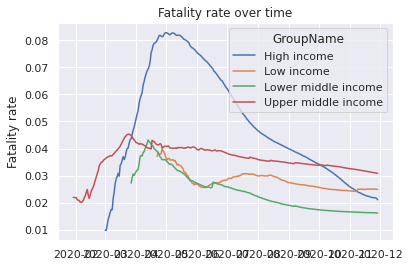

In [22]:
sns.lineplot(x="date", y="fatality_rate", hue = "GroupName", data = dfx)
plt.title("Fatality rate over time")
plt.xlabel("")
plt.ylabel("Fatality rate")
plt.show()

In [23]:
dfx3 = df[(df["date"] == "2020-11-27") & (df["total_cases"] > 1000)]

Na tym wykresie natomiast widać, że najmniej ludzi umiera z powodu koronawirusa w krajach najmniej zamożnych.

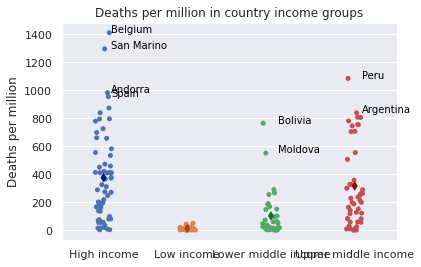

In [24]:
sns.stripplot(data = dfx3, x = "GroupName", y= "total_deaths_per_million", dodge=True,zorder=1)
sns.pointplot(data = dfx3, x = "GroupName", y= "total_deaths_per_million",
              dodge=.532, join=False, palette="dark",
              markers="d", scale=.75, ci=None)
# może podpisać outliersy, ale nie zdążyłem
for line in range(0,dfx3.shape[0]):
    if dfx3.total_deaths_per_million[line]>900 and dfx3.GroupName[line] == "High income":
        plt.text(0.09, dfx3.total_deaths_per_million[line], 
             dfx3.CountryName[line], horizontalalignment='left', size='medium',color='black')
    if dfx3.total_deaths_per_million[line]>820 and dfx3.GroupName[line] == "Upper middle income":
        plt.text(3.09, dfx3.total_deaths_per_million[line], 
             dfx3.CountryName[line], horizontalalignment='left', size='medium',color='black')
    if dfx3.total_deaths_per_million[line]>400 and dfx3.GroupName[line] == "Lower middle income":
        plt.text(2.09, dfx3.total_deaths_per_million[line], 
             dfx3.CountryName[line], horizontalalignment='left', size='medium',color='black')

plt.xlabel("")
plt.title("Deaths per million in country income groups")
plt.ylabel("Deaths per million")
plt.show()

In [25]:
gdp_change = pd.read_excel("https://github.com/mikolajsp/mini-objective-java/blob/master/gdp_change.xls?raw=true")
gdp_change = gdp_change.set_index("CountryName")

In [26]:
df_w = df[["CountryName", "total_deaths_per_million", "total_cases", "date", "GroupName"]]

In [27]:
df_w = df_w[df_w["date"] == "2020-11-27"].set_index("CountryName").join(gdp_change, how = "inner")

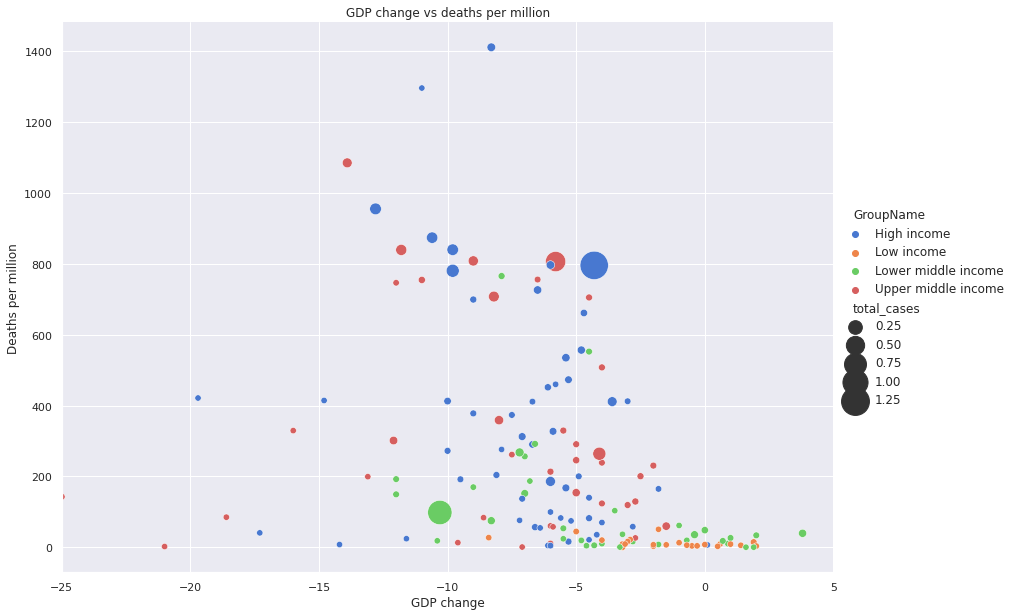

In [28]:
sns.set(rc={'figure.figsize':(18,8)})
sns.relplot(x="change", y="total_deaths_per_million", hue="GroupName", size="total_cases", 
            sizes=(40, 800),
            height=8.27, aspect=11.7/8.27, palette="muted", data=df_w)
plt.xlim([-25, 5])
plt.title("GDP change vs deaths per million")
plt.xlabel("GDP change")
plt.ylabel("Deaths per million")
plt.show()

In [29]:
x1 = df[(df["date"] == "2020-11-27")][["GroupName", "total_deaths"]].groupby("GroupName").sum()

In [30]:
x1["share_in_deaths"] = x1["total_deaths"]/np.sum(x1.total_deaths)*100

In [31]:
x1["estimated_share_in_deaths"] = [18.1, 34.5, 38.9, 8.5]

[]

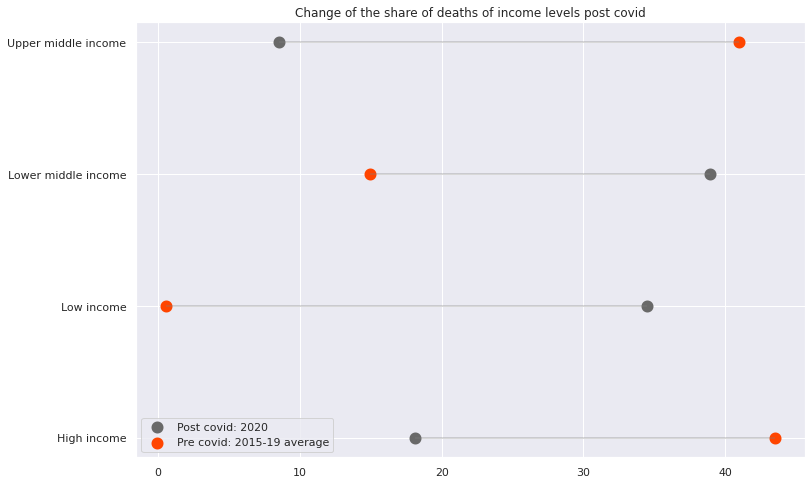

In [32]:
sns.set(rc={'figure.figsize':(12,8)})
plt.hlines(y = x1.index, xmin = x1["estimated_share_in_deaths"], xmax = x1["share_in_deaths"], color = 'grey', alpha = 0.4)
plt.scatter(x1['estimated_share_in_deaths'], x1.index, color = 'dimgrey', linewidths = 6, label = "Post covid: 2020")
plt.scatter(x1['share_in_deaths'], x1.index, color = 'orangered', linewidths = 6, label = 'Pre covid: 2015-19 average')
plt.legend(loc="lower left")
plt.title("Change of the share of deaths of income levels post covid")
plt.plot()

In [33]:
import datetime
x2 = df

In [34]:
x2["month"] = pd.DatetimeIndex(x2['date']).month
x2["year"] = pd.DatetimeIndex(x2['date']).year
x2 = x2[x2["year"] == 2020]

In [35]:
x2 = x2.groupby(["month", "CountryName", "GroupName"]).max("new_cases_smoothed").reset_index()


In [36]:
def label_fala (row):
    if row["month"] <= 8:
      return "I"
    else:
      return "II"

In [37]:
x2["fala"] = x2.apply(lambda row: label_fala(row), axis = 1)
idx = x2.groupby(["fala", "CountryName"])["new_cases_smoothed"].transform(max) == x2["new_cases_smoothed"]
x2 = x2[idx]
x2 = x2[["CountryName", "GroupName", "new_cases_smoothed", "fala"]]
x2 = x2.reset_index()
x22 = x2.pivot_table(index = ["CountryName", "GroupName"], columns = "fala", values = "new_cases_smoothed" )
x22 = x22.reset_index()
def group_by_worse_wave (row):
    if abs(row["I"]-row["II"]) <= 0.2 * min(row["I"], row["II"]):
      return "similar"
    if row["I"] >= row["II"]:
      return "1st wave"
    return "2nd wave"

In [38]:
x22["worse_wave"] = x22.apply(lambda row: group_by_worse_wave(row), axis = 1)
x22

fala,CountryName,GroupName,I,II,worse_wave
0,Afghanistan,Low income,758.571,221.571,1st wave
1,Albania,Upper middle income,159.429,739.143,2nd wave
2,Algeria,Lower middle income,622.429,1065.429,2nd wave
3,Andorra,High income,33.857,112.429,2nd wave
4,Angola,Lower middle income,73.571,261.857,2nd wave
...,...,...,...,...,...
198,Virgin Islands (U.S.),High income,35.571,20.143,1st wave
199,West Bank and Gaza,Lower middle income,577.000,1569.714,2nd wave
200,"Yemen, Rep.",Low income,52.143,9.571,1st wave
201,Zambia,Lower middle income,301.000,156.571,1st wave


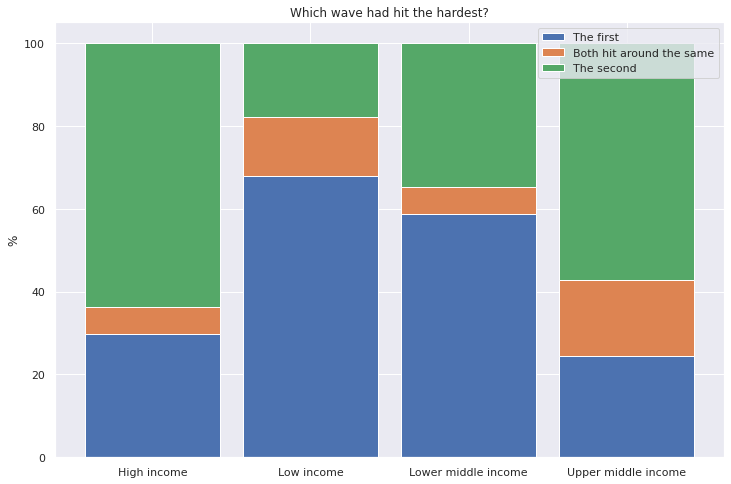

In [39]:
x22 = x22.groupby(["GroupName", "worse_wave"]).count().reset_index()
x22 = x22.pivot_table(index = "GroupName", columns = "worse_wave", values = "I").reset_index()
totals = [i+j+k for i,j,k in zip(x22['1st wave'], x22['2nd wave'], x22['similar'])]
first = [i / j * 100 for i,j in zip(x22['1st wave'], totals)]
second = [i / j * 100 for i,j in zip(x22['2nd wave'], totals)]
similar = [i / j * 100 for i,j in zip(x22['similar'], totals)]
# no tu kolory są do zmiany w ogóle XD
barWidth = 0.85
plt.bar(x22["GroupName"], first,  width=barWidth,label="The first") #większe maksymalne liczby przypadków w I fali
plt.bar(x22["GroupName"], similar, bottom=first, width=barWidth,label="Both hit around the same") #podobne maksymalne liczby przypadki w obu falach
plt.bar(x22["GroupName"], second, bottom=[i+j for i,j in zip(first, similar)], width=barWidth,label="The second") #większe maksymalne liczby przypadków w II fali
plt.title("Which wave had hit the hardest?")
plt.legend()
plt.xlabel("")
plt.ylabel("%")
plt.show()